## Projet: Facebook BaBi tasks <em>Notebook 28/03/2018<em>

Dans ce notebook, nous avons récrit (juste de petites modifications) sur le parseur et la tokenarisation. Nous avons aussi rajouté la fonction de vectorisation (Transformer une phrase en tableau).

Un modèle a aussi été créé selon ce qui nous avions défini dans le notebook précédent. Nous avons ainsi pu commencer a faire des tests avec le modèle, et nous avons eu des résultats plutôt moyens sur la première task, environ 43% de précision. Il nous faut investiguer plus le problème pour améliorer nos performances, peut être en utilisant différents réseaux récurrents. Le réseau récurrent utilisé est LSTM sur ce notebook.

Reste à perfectionner le modèle et/ou les autres paramètres. Essayer les autres tasks également. Utiliser un Memory Network pour après?


In [1]:
import re

def tokenize(sent):
    '''Renvoie les jetons d'une phrase, y compris la ponctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

#parsing
def parserBabi(data):
    '''Parseur des Histoires fournies dans le format de bAbi tasks
    Si only_supporting est true,
    seules les phrases qui soutiennent la réponse sont conservées.
    '''
    ret=list()
    story=list()
    
    for phrase in data:
        phrase = phrase.decode('utf-8').strip()
        id_phrase,phrase = int(phrase[0]),phrase[1:]
        
        if id_phrase == 1: #Nouvelle story
            story=list()
            
        if '\t' in phrase: #Si tabulation alors il s'agit de la question ainsi que de la réponse
            q, a, justif = phrase.split('\t')
            q = tokenize(q)
            
            data_story = [x for x in story if x] 
                                             
            ret.append((data_story,q,a)) #Nos données d'apprentissages
            story.append('')
        
        else: 
            #Alors la phrase est tout simplement un des élements de raisonnement et non une question
            story.append(tokenize(phrase))
            
    return ret

#Lecture de la phrase et parssing
def readAndParse(f):
    '''
    Étant donné un nom de fichier, lisez le fichier, récupérez les histoires,
    puis convertissez les phrases en une seule histoire.
    Si max_length est fourni,
    les histoires plus longues que les jetons max_length seront ignorées.
    '''
    data = parserBabi(f.readlines())
    return [([substory for substories in story for substory in substories], q , a) for story,q,a in data]


## Récupération des donées
Nous allons lancer un téléchargement des données depuis internet et ça n'aboutit pas on demande de la faire manuellment à aprtir des commandes fournis.<br>
<em>Si les données sont déjà téléchargées, get_file ne va pas rétélegarder</em>

In [2]:
from keras.utils.data_utils import get_file
import tarfile

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Erreur de téléchargement, Veillez le télécharger manuellement'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

Using TensorFlow backend.


### Observation
Onbservons les données de la prémière tache. Le vocabulaire, l'apprentissage et le test

In [3]:
from functools import reduce    
# On récupère la tache 1
tar = tarfile.open(path)
challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'

train = readAndParse(tar.extractfile(challenge.format('train')))
test = readAndParse(tar.extractfile(challenge.format('test')))

vocab = sorted(reduce(lambda x, y: x | y, (set(story + q + [answer]) for story, q, answer in train + test)))
vocab_size = len(vocab) + 1
word_idx = dict(((w,i+1) for i,w in enumerate(vocab)))

story_max = max((len(x) for x,_,_ in train+test))
question_max = max((len(x) for _,x,_ in train+test))


/home/hasmiou/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [4]:
print("Contenu de la tache 1:")
#print("----train--------:\n",train)
#print("----test---------:\n",test)
#print("----vocab--------:\n",vocab)
print("----vocab_size---:\n",vocab_size)
#print("----word_idx-----:\n",word_idx)
print("----story_max----:\n",story_max)
print("----question_max-:\n",question_max)

Contenu de la tache 1:
----vocab_size---:
 24
----story_max----:
 40
----question_max-:
 5


### Vectorisation

Cela consiste à transfomer les données en une matrice afin de pouvoir entrainer notre réseau neuronal.
La fonction `pad_sequences` plus bas permet de transformer notre liste de liste en matrice numpy en ajoutant des 0. pour complèter quand il n'y a pas de données.


In [5]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

#source : https://github.com/keras-team/keras/blob/master/examples/babi_rnn.py
def vectorize(data, word_idx, story_maxlen, query_maxlen):
    xs, xqs, ys = [], [], []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return pad_sequences(xs, maxlen=story_maxlen), pad_sequences(xqs, maxlen=query_maxlen), np.array(ys)

X, Xq, Y = vectorize(train, word_idx, story_max, question_max)
X_test, Xq_test, Y_test = vectorize(test, word_idx, story_max, question_max)

In [6]:
#print("--Histoire---:\n",X[0:10])
#print("--Questions--:\n",Xq[0:10])
#print("--Reponses---:\n",Y[0:10])
#print('vocab = {}'.format(vocab))
#print('x.shape = {}'.format(X.shape))
#print('xq.shape = {}'.format(Xq.shape))
#print('y.shape = {}'.format(Y_test.shape))
#print('story_maxlen, query_maxlen = {}, {}'.format(story_max, question_max))

### Modèle
Nous allons créer les modèles keras pour les histoires et les questions puis de les merger en un seul modèle.<br>
On a un LSTM Long Short-Term Memory layer (Longue couche de mémoire à court terme) dans le modèle des story car il faut raisonner d'abord sur les stories seules puis les story avec les questions (raisonner sur les questions seule ne veut pas dire grand chose)<br>
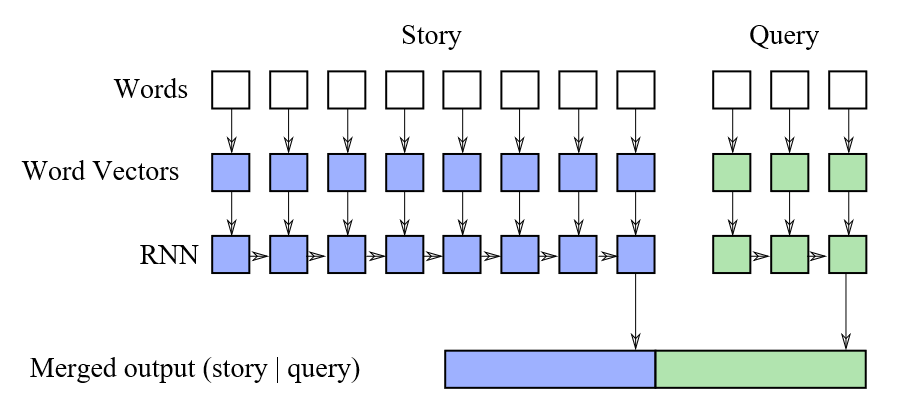

In [7]:
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam

In [8]:
embed_size = 50
batch_size=32
epochs=60

#Model sequentiel des histoire
story_model = Sequential()
story_model.add(Embedding(vocab_size,embed_size,input_length=story_max))

#Model  sequentiel des question
question_model = Sequential()
question_model.add(Embedding(vocab_size,embed_size,input_length=question_max))
question_model.add(LSTM(embed_size))
question_model.add(RepeatVector(story_max)) #permet d'ajuster la taille du modèle afin de préparer un merge

#Model du reseau comportant les models du story et des questionnaires
model = Sequential()
#fusion des models
model.add(Merge([story_model, question_model], mode='sum'))
#On definit la dimension de l'espace de sortie et la fonction d'activation est tangente hyperbolique( tanh).
model.add(LSTM(embed_size))
#Definition de la densité de connexion du RNN
model.add(Dense(vocab_size))
#Definission de la fonction d'activation "SoftMax"
model.add(Activation("softmax"))
#Fonction de perte CrossEntrepy et l'optimiseur
model.compile(optimizer=RMSprop(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

#Entrainement du model
model.fit([X, Xq], Y, batch_size=batch_size, epochs=epochs)


/home/hasmiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Epoch 1/60
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9568 - acc: 0.1580
Epoch 2/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8174 - acc: 0.1920
Epoch 3/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6111 - acc: 0.3550
Epoch 4/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4958 - acc: 0.4060
Epoch 5/60
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4107 - acc: 0.4040A: 0s - loss: 1.4084 - acc: 0.4
Epoch 6/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.3525 - acc: 0.4240
Epoch 7/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.3051 - acc: 0.4350
Epoch 8/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2683 - acc: 0.4410
Epoch 9/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2676 - acc: 0.4250
Epoch 10/60
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2173 - acc: 0.457

<b>Remarque </b>:<p> lorsque vous utilisez la fonction de perte `categorical_crossentropy`, nos cibles doivent être dans un format catégorique (par exemple, si vous avons 10 classes, la cible pour chaque échantillon doit être un vecteur 10-zéros à part un 1 à l'index correspondant à la classe de l'échantillon).</p>
<b>Notes</b>:<br>
- Avec un batchsize de 32 un nombre de 60 epochs semble optimal.
- Le fait d'avoir utilisé un petit batchsize a amelioré les résultats (32 optimal)


### Calcul des performances du model


In [9]:
loss,acc = model.evaluate([X_test, Xq_test],Y_test, batch_size=batch_size)
print("Perte = ", round(loss,2),"%")
print("Précision = ", round(acc, 2)*100.0, "%")

1000/1000 [==============================] - 1s 1ms/step
Perte =  2.28 %
Précision =  43.0 %
